In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('LoanStats3d.csv', low_memory=False)

In [4]:
print df.head(1)
df.info(verbose=True, null_counts=True)

         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68615169   73517949      16000        16000          16000.0   60 months   

  int_rate  installment grade sub_grade            ...              \
0    8.49%       328.19     B        B1            ...               

  num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75  \
0                  0                  3           87.5              50.0   

  pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex_mort  \
0                    0         0          307343             64371   

  total_bc_limit total_il_high_credit_limit  
0          23500                      59526  

[1 rows x 111 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 111 columns):
id                                421095 non-null int64
member_id                         421095 non-null int64
loan_amnt                         421095 non-null int64
funded_amn

# Cleaning and dropping redundant/useless features

In [5]:
#First step is to load the dataset into a Pandas DataFrame. 
#We can see this is an incredibly rich dataset with over 100 features and 400,000+ originated loans.
#Time to do some preliminary clean-up/simplifying before jumping into the analysis/question prompts.
members = df['member_id'].value_counts()
members[members>1]

Series([], Name: member_id, dtype: int64)

In [6]:
#All the member_ids are unique so we will delete them as well as the id
to_delete = ['member_id', 'id']
print 'any loans where loan_amnt doesn"t equal funded_amnt? \n', (df.loan_amnt != df.funded_amnt).value_counts()
print '-------------------------------------------------------'
print df[(df.loan_amnt != df.funded_amnt_inv)][['funded_amnt', 'funded_amnt_inv']][:5]
print '-------------------------------------------------------'
df['term'] = df['term'].str.extract('(\d+)').astype(int) ##changing term feature to integer for further use
df['int_rate'] = df['int_rate'].str[:-1].astype(float) / 100
subgrades = df['sub_grade'].unique()
print subgrades

any loans where loan_amnt doesn"t equal funded_amnt? 
False    421095
dtype: int64
-------------------------------------------------------
      funded_amnt  funded_amnt_inv
1470        30000          29950.0
1530         8400           8375.0
1766        15000          14925.0
2193        15000          14950.0
2558        27000          26975.0
-------------------------------------------------------


/Users/jcwall/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


['B1' 'B4' 'C1' 'A5' 'C2' 'C4' 'E3' 'B3' 'C3' 'B2' 'D3' 'B5' 'A4' 'A2' 'C5'
 'E4' 'D2' 'A1' 'F1' 'D5' 'D1' 'E2' 'D4' 'F2' 'F3' 'A3' 'F5' 'E5' 'E1' 'G1'
 'G2' 'G3' 'G4' 'F4' 'G5']


In [7]:
#We will add grade, funded_amnt and funded_amnt_inv to drop, funded_amnt_inv is all values off by small multiples of 25 which 
#seems like Lending Club approves them before there are actually enough investors? Grade is redundant with subgrades.
#but is used in orig fee calc later
to_delete.extend(['funded_amnt', 'funded_amnt_inv'])
#cleanup emp_length so each value is numeric
df['emp_length'].replace('n/a', np.nan, inplace=True)
df['emp_length'].fillna(0, inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', regex=True, inplace=True)

In [8]:
#verification_status_joint mostly Nans so dropped, pymnt_plan had 2 yes which were late 31-120 days so redundant, url 
#is a login page, desc is usually already decribed in purpose column, title == purpose
to_delete.extend(['verification_status_joint', 'pymnt_plan', 'url', 'desc', 'title', 'inq_last_6mths'])
#verified or not?
df['verification_status'] = df['verification_status'].apply(lambda x: 0 if 'Not' in x else 1)
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df.ix[:2, 10:30]
#dti interesting but omits mortgage and LC loan from metrics

,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record
0,Supervisor,5,MORTGAGE,62000.0,1,2015-12-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,936xx,CA,28.92,0,Mar-2002,0,39.0,NaN
1,Counselor,1,MORTGAGE,45000.0,0,2015-12-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,482xx,MI,21.23,0,Jan-1998,0,34.0,NaN
2,Lpn,3,MORTGAGE,41600.0,0,2015-12-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,472xx,IN,15.78,0,Oct-2004,0,NaN,NaN


In [9]:
df['default'] = df['loan_status'].apply(lambda x: 1 if x in (['Charged Off', 'Default', 'Late (31-120 days)']) else 0)
df['earliest_cr_line'].str.extract('(\d+)').astype(int)
df['mths_since_last_major_derog'].replace('nan', np.nan, inplace=True)
df['mths_since_last_major_derog'].fillna(0, inplace=True)

#previous major delinquency? 
df['mths_since_last_major_derog'] = df['mths_since_last_major_derog'].apply(lambda x: 1 if x != 0 else 0)
to_delete.extend(['mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq'])

/Users/jcwall/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [10]:
df['open_acc2'] = pd.cut(df['open_acc'], [0, 5, 10, 15, 20, 25, 35, 1000], labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-35', '35+'])
open_acc = df.pop('open_acc')
#total acc correlated to open_acc, initial_list_status for investors
to_delete.extend(['total_acc', 'initial_list_status', 'out_prncp_inv', 'total_pymnt_inv', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'annual_inc_joint', 'dti_joint'])
to_delete.extend(['open_il_6m', 'open_il_12m', 'open_il_24m', 'il_util', 'open_rv_12m', 'open_rv_24m', 'all_util', 'total_cu_tl', 'inq_last_12m'])
df['total_rec_late_fee'] = df['total_rec_late_fee'].apply(lambda x: 0 if x == 0 else 1)

In [11]:
to_delete.extend(['mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', ])

In [12]:
df2 = df.copy()
df.drop(to_delete, axis=1, inplace=True)
df.head(2)
df.columns

Index([u'loan_amnt', u'term', u'int_rate', u'installment', u'grade',
       u'sub_grade', u'emp_title', u'emp_length', u'home_ownership',
       u'annual_inc', u'verification_status', u'issue_d', u'loan_status',
       u'purpose', u'zip_code', u'addr_state', u'dti', u'delinq_2yrs',
       u'earliest_cr_line', u'mths_since_last_delinq', u'pub_rec',
       u'revol_bal', u'revol_util', u'out_prncp', u'total_pymnt',
       u'total_rec_prncp', u'total_rec_int', u'total_rec_late_fee',
       u'recoveries', u'collection_recovery_fee', u'last_pymnt_d',
       u'last_pymnt_amnt', u'next_pymnt_d', u'mths_since_last_major_derog',
       u'application_type', u'acc_now_delinq', u'tot_coll_amt', u'tot_cur_bal',
       u'open_acc_6m', u'total_bal_il', u'max_bal_bc', u'total_rev_hi_lim',
       u'inq_fi', u'acc_open_past_24mths', u'avg_cur_bal', u'bc_open_to_buy',
       u'bc_util', u'chargeoff_within_12_mths', u'delinq_amnt',
       u'mo_sin_rcnt_rev_tl_op', u'mort_acc', u'num_actv_bc_tl',
       u'n

In [13]:
#after cleaning out a lot of redundant/correlated features (for simplicity's sake for this analysis) -- Time to answer
#some questions and use visualizations to understand borrowers, loans and Lending Club's business line further.

# Is Lending Club Making Money with the Loans in the dataset?
## Yes -- They charge an origination fee of 1-5% (https://www.lendingclub.com/public/borrower-rates-and-fees.action). They also collect a 1% fee on every installment made from borrowers and collected by investors, as well as 35% of amount received from collections with no litigation, or 30% of attorney's fees plus costs if there is litigation. Furthermore, there is a 15.00 unsuccessful payment fee, late payment fee is max(.05*installment, 15.00), and a check processing fee of 7.00. No fee for paying off loan early, and none taken by LC from lenders unless paid off over a year after origination. Going to assume target market for LC is borrowers who are current throughout duration of loan or those who pay off after a year.

In [14]:
#3.46 based on LC metric for Q1 2017
df['terms_paid'] = (df['last_pymnt_d'].dt.date - df['issue_d'].dt.date) / np.timedelta64(1, 'M')
orig_fee_lib = {'A': .0346, 'B': .05, 'C': .06, 'D': .06, 'E': .06, 'F': .06, 'G': .06}
df['orig_rate'] = df['grade'].apply(lambda x: orig_fee_lib[x])
df['orig_fee'] = df['orig_rate'] * df['loan_amnt']
sum_orig_fees = df['orig_fee'].sum()
sum_late_fees = df['total_rec_late_fee'].sum()
sum_coll_fees = df['collection_recovery_fee'].sum()
paid_off_after_year = df.query("loan_status == 'Fully Paid' & terms_paid > 12")
paid_off_after_year_sum = paid_off_after_year['orig_fee'].sum() + paid_off_after_year['total_pymnt'].sum() * .01
paid_off_less_12 = df[(df['loan_status'] == 'Fully Paid') & (df['terms_paid'] <= 12)]
paid_off_bfor_year_sum = paid_off_less_12['orig_fee'].sum() + (paid_off_less_12['total_pymnt'] - paid_off_less_12['last_pymnt_amnt']).sum() * .01
late_120_days = df[df['loan_status'] == 'Late (31-120 days)']['orig_fee'].sum() + df[df['loan_status'] == 'Late (31-120 days)']['total_pymnt'].sum() * .01
late_30_days = df[df['loan_status'] == 'Late (16-30 days)']['orig_fee'].sum() + df[df['loan_status'] == 'Late (16-30 days)']['total_pymnt'].sum() * .01
current_or_grace = df[df['loan_status'] == 'Current']['orig_fee'].sum() + df[df['loan_status'] == 'In Grace Period']['orig_fee'].sum() + df[df['loan_status'] == 'Current']['total_pymnt'].sum() * .01 + df[df['loan_status'] == 'In Grace Period']['total_pymnt'].sum() * .01
default_charged = df[(df['loan_status'] == 'Default') | (df['loan_status'] == 'Charged Off')]
default_charged_sum = default_charged['orig_fee'].sum() + default_charged['total_pymnt'].sum() * .01 + df['collection_recovery_fee'].sum()

In [15]:
print 'current_or_grace:', current_or_grace, round(current_or_grace / 1000000, 2), 'm'
print 'paid_off_after_year:', paid_off_after_year_sum, round(paid_off_after_year_sum / 1000000, 3), 'm'
print 'paid_off_before_year:', paid_off_bfor_year_sum, round(paid_off_bfor_year_sum / 1000000, 3), 'm'
print 'late 31-120 days:', late_120_days, round(late_120_days / 1000000, 3), 'm'
print 'late 30 days:', late_30_days, round(late_30_days / 1000000, 3), 'm'
print 'default or charged off:', default_charged_sum, round(default_charged_sum / 1000000, 2), 'm'
print 'TOTAL rev for data set for Lending Club:', (current_or_grace + paid_off_after_year_sum + paid_off_bfor_year_sum + late_120_days + late_30_days + default_charged_sum + sum_late_fees) / 1000000, 'm'
print 'orig fees:', sum_orig_fees / 1000000

current_or_grace: 250691756.303 250.69 m
paid_off_after_year: 41831830.3239 41.832 m
paid_off_before_year: 41157256.9963 41.157 m
late 31-120 days: 8411847.9812 8.412 m
late 30 days: 1624605.8049 1.625 m
default or charged off: 36607863.3066 36.61 m
TOTAL rev for data set for Lending Club: 380.332879716 m
orig fees: 340.92839911


In [16]:
print 'overall % of loans by grade\n', df['grade'].value_counts() / len(df)
print 'overall % of paid off before_year_loans by grade\n', df[(df['loan_status'] == 'Fully Paid') & (df['terms_paid'] <= 12)]['grade'].value_counts() / len(df[(df['loan_status'] == 'Fully Paid') & (df['terms_paid'] <= 12)])

overall % of loans by grade
C    0.286318
B    0.279286
A    0.174155
D    0.148788
E    0.082993
F    0.023313
G    0.005146
Name: grade, dtype: float64
overall % of paid off before_year_loans by grade
C    0.292145
B    0.267297
D    0.158348
A    0.156511
E    0.090245
F    0.028166
G    0.007288
Name: grade, dtype: float64


## Paid loans within a year for grade aggregates shows the distribution is fairly consistent with the overall dataset
# What slices of loans make the most money?

In [17]:
print 'NUMBER OF BORROWERS'
print df['loan_status'].value_counts()
print 'current_or_grace:', round(current_or_grace / len(df[df['loan_status'] == 'Current']), 2) , 'per borrower'
print 'paid_off_after_year:', round(paid_off_after_year_sum / len(df.query("loan_status == 'Fully Paid' & terms_paid >= 12")), 2), 'per borrower'
print 'paid_off_before_year:', round(paid_off_bfor_year_sum / len(df[(df['loan_status'] == 'Fully Paid') & (df['terms_paid'] < 12)]), 2), 'per borrower'
print 'late 31-120 days:', round(late_120_days / len(df[df['loan_status'] == 'Late (31-120 days)']), 2), 'per borrower'
print 'late 30 days:', round(late_30_days / len(df[df['loan_status'] == 'Late (16-30 days)']), 2), 'per borrower'
print 'default or charged off:', round(default_charged_sum / len(df[(df['loan_status'] == 'Default') | (df['loan_status'] == 'Charged Off')]), 2), 'per borrower'
print 'average rev per loan for Lending Club:', round((current_or_grace + paid_off_after_year_sum + paid_off_bfor_year_sum + late_120_days + late_30_days + default_charged_sum + sum_late_fees) / len(df), 2), 'per borrower'

NUMBER OF BORROWERS
Current               277527
Fully Paid             94968
Charged Off            33416
Late (31-120 days)      8626
In Grace Period         4674
Late (16-30 days)       1624
Default                  260
Name: loan_status, dtype: int64
current_or_grace: 903.31 per borrower
paid_off_after_year: 943.45 per borrower
paid_off_before_year: 812.92 per borrower
late 31-120 days: 975.17 per borrower
late 30 days: 1000.37 per borrower
default or charged off: 1087.06 per borrower
average rev per loan for Lending Club: 903.2 per borrower


In [18]:
#Revenue by borrower grade
df_plw1y = df[(df['loan_status'] != 'Fully Paid') | ((df['loan_status'] == 'Fully Paid') & (df['terms_paid'] <= 12))]
a, b, c, d, e, f, g = df_plw1y[df_plw1y['grade']=='A'], df_plw1y[df_plw1y['grade']=='B'], df_plw1y[df_plw1y['grade']=='C'], df_plw1y[df_plw1y['grade']=='D'], df_plw1y[df_plw1y['grade']=='E'], df_plw1y[df_plw1y['grade']=='F'], df_plw1y[df_plw1y['grade']=='G']
A = a['orig_fee'].sum() + a['total_pymnt'].sum() * .01 + a['total_rec_late_fee'].sum() + a['collection_recovery_fee'].sum()
B = b['orig_fee'].sum() + b['total_pymnt'].sum() * .01 + b['total_rec_late_fee'].sum() + b['collection_recovery_fee'].sum() 
C = c['orig_fee'].sum() + c['total_pymnt'].sum() * .01 + c['total_rec_late_fee'].sum() + c['collection_recovery_fee'].sum() 
D = d['orig_fee'].sum() + d['total_pymnt'].sum() * .01 + d['total_rec_late_fee'].sum() + d['collection_recovery_fee'].sum() 
E = e['orig_fee'].sum() + e['total_pymnt'].sum() * .01 + e['total_rec_late_fee'].sum() + e['collection_recovery_fee'].sum() 
F = f['orig_fee'].sum() + f['total_pymnt'].sum() * .01 + f['total_rec_late_fee'].sum() + f['collection_recovery_fee'].sum() 
G = g['orig_fee'].sum() + g['total_pymnt'].sum() * .01 + g['total_rec_late_fee'].sum() + g['collection_recovery_fee'].sum() 

In [19]:
print 'A:', A, len(a), round(A / len(a), 2), 'per borrower'
print 'B:', B, len(b), round(B / len(b), 2), 'per borrower'
print 'C:', C, len(c), round(C / len(c), 2), 'per borrower'
print 'D:', D, len(d), round(D / len(d), 2), 'per borrower'
print 'E:', E, len(e), round(E / len(e), 2), 'per borrower'
print 'F:', F, len(f), round(F / len(f), 2), 'per borrower'
print 'G:', G, len(g), round(G / len(g), 2), 'per borrower'

A: 38319099.0451 63774 600.86 per borrower
B: 83791526.4357 104506 801.79 per borrower
C: 106248234.323 108250 981.51 per borrower
D: 60971487.2784 56946 1070.69 per borrower
E: 39961760.8443 32171 1242.17 per borrower
F: 12467703.6021 9114 1367.97 per borrower
G: 2837516.24035 1995 1422.31 per borrower


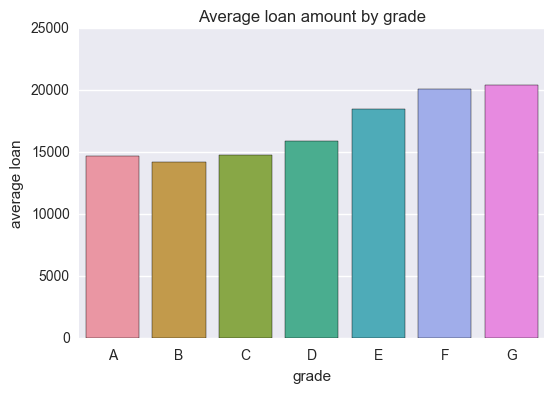

In [20]:
xy = df.groupby('grade')['loan_amnt'].mean()
ax = sns.barplot(x=xy.index, y=xy.values, data=df)
ax.set_ylabel('average loan')
ax.set_title('Average loan amount by grade')

# Characteristics of good/bad borrowers 

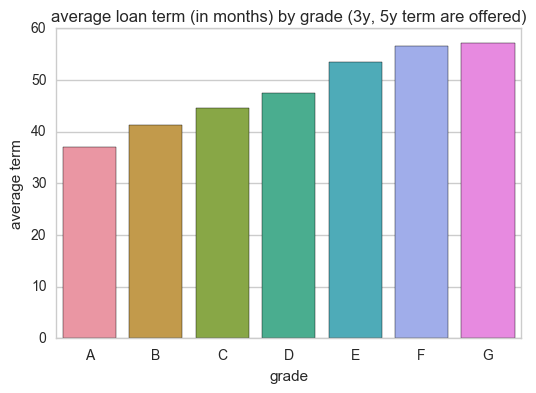

In [21]:
sns.set_style('whitegrid')
xy = df.groupby('grade')['term'].mean()
ax = sns.barplot(x=xy.index, y=xy.values, data=df)
ax.set_ylabel('average term')
ax.set_title('average loan term (in months) by grade (3y, 5y term are offered)')

## Good borrowers request smaller terms (for smaller amounts)!

In [22]:
df.groupby('verification_status')['default'].mean()

verification_status
0    0.070599
1    0.112152
Name: default, dtype: float64

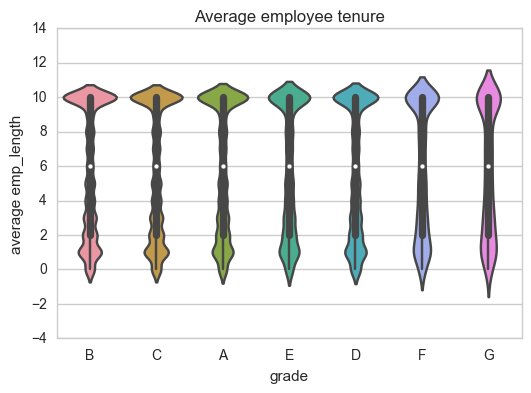

In [23]:
df['emp_length'] = df['emp_length'].astype(int)
ax = sns.violinplot(x = 'grade', y = 'emp_length', data=df[['grade', 'emp_length']])
ax.set_ylabel('average emp_length')
ax.set_title('Average employee tenure')

## Emp_length, verification status have almost no effect on rating

In [24]:
good_bor = df[(df['grade'] == 'A') | (df['grade'] == 'B')]
poor_bor = df[(df['grade'] == 'E') | (df['grade'] == 'F') | (df['grade'] == 'G')]
print good_bor['bc_util'].mean(), poor_bor['bc_util'].mean()

55.9143712039 68.4947455308


In [25]:
df['default'] = df['loan_status'].apply(lambda x: 1 if x in ('Default','Charged Off', 'Late (31-120 days)') else 0) 

In [26]:
print 'default for whole set', df['default'].sum() / float(len(df))
print 'default by \n', df.groupby('grade')['default'].mean()

default for whole set 0.1004571415
default by 
grade
A    0.025799
B    0.058033
C    0.105568
D    0.160628
E    0.206907
F    0.287359
G    0.341947
Name: default, dtype: float64


In [27]:
# sns.jointplot(y,df.meanfico.values,annot_kws=dict(stat="r"),
#               kind="kde", color="#4CB391").set_axis_labels("int_rate", "mean_fico")

In [28]:
state_default_rates = df.groupby('addr_state')['default'].mean()
print state_default_rates.nlargest(10)
print state_default_rates.nsmallest(10)

addr_state
SD    0.138922
NV    0.126772
AL    0.126239
OK    0.123740
AR    0.120241
LA    0.118478
AK    0.118449
MS    0.114153
NM    0.111867
NY    0.111689
Name: default, dtype: float64
addr_state
ME    0.036468
NH    0.059651
VT    0.062780
OR    0.072006
KS    0.073340
ND    0.075157
WI    0.079287
SC    0.079905
DC    0.080517
MT    0.080895
Name: default, dtype: float64


## Strong correlation by states althought somewhat flawed by sample size

In [29]:
df.groupby('open_acc2')['default'].mean()

open_acc2
0-5      0.090215
5-10     0.097021
10-15    0.103382
15-20    0.103631
20-25    0.108862
25-35    0.113108
35+      0.121311
Name: default, dtype: float64

In [30]:
#df['revol_util'] = df['revol_util'].str[:-1].astype(float) / 100
df['revol_util2'] = pd.cut(df['revol_util'], [0, .2, .4, .6, .8, 1], labels=['0%-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
df.groupby('revol_util2')['default'].mean()

revol_util2
0%-20%    NaN
20-40%    NaN
40-60%    NaN
60-80%    NaN
80-100%   NaN
Name: default, dtype: float64

In [31]:
df['dti2'] = df['dti'] / 100
df['dti2'] = pd.cut(df['dti2'], [0, .2, .4, .6, .8, 1], labels=['0%-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
df.groupby('dti2')['default'].mean()

dti2
0%-20%     0.083267
20-40%     0.122197
40-60%     0.081967
60-80%     0.071429
80-100%    0.000000
Name: default, dtype: float64

In [32]:
df.groupby('application_type')['default'].mean()

application_type
INDIVIDUAL    0.100479
JOINT         0.082192
Name: default, dtype: float64

In [33]:
df.groupby('grade')['annual_inc'].mean()

grade
A    91315.797769
B    79193.286111
C    72799.003201
D    68462.794921
E    70850.364979
F    71779.296553
G    70203.390281
Name: annual_inc, dtype: float64

In [34]:
df['tbi2'] = pd.cut(df['total_bal_il'], [0, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 1000000], labels=['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-30000', '30000-50000', '50000-100000', '100000+'])
df.groupby('tbi2')['default'].mean()

tbi2
0-5000          0.056529
5000-10000      0.071510
10000-15000     0.065128
15000-20000     0.076965
20000-30000     0.078105
30000-50000     0.087800
50000-100000    0.079013
100000+         0.077364
Name: default, dtype: float64

In [35]:
df['tcb2'] = pd.cut(df['tot_cur_bal'], [0, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 1000000], labels=['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-30000', '30000-50000', '50000-100000', '100000+'])
df.groupby('tcb2')['default'].mean()

tcb2
0-5000          0.100641
5000-10000      0.098191
10000-15000     0.105908
15000-20000     0.110472
20000-30000     0.116007
30000-50000     0.117529
50000-100000    0.116916
100000+         0.084546
Name: default, dtype: float64

In [36]:
print good_bor['emp_title'].value_counts()[:10]
print poor_bor['emp_title'].value_counts()[:10]

Teacher             3849
Manager             3073
Owner               1998
Registered Nurse    1608
RN                  1573
Supervisor          1253
Project Manager     1242
Sales               1237
Director            1094
owner                970
Name: emp_title, dtype: int64
Manager             785
Teacher             776
Supervisor          384
Owner               376
Registered Nurse    321
RN                  305
Driver              292
Sales               265
manager             233
Office Manager      225
Name: emp_title, dtype: int64


In [37]:
df.groupby('home_ownership')['default'].mean()

home_ownership
ANY         0.000000
MORTGAGE    0.084027
OWN         0.104226
RENT        0.119784
Name: default, dtype: float64

In [38]:
purpose = df.groupby('purpose')['default'].mean()
print purpose.nlargest(5)
print purpose.nsmallest(5)

purpose
small_business      0.173603
renewable_energy    0.156250
house               0.149513
moving              0.144215
medical             0.116557
Name: default, dtype: float64
purpose
educational         0.000000
wedding             0.000000
credit_card         0.075521
car                 0.084535
home_improvement    0.091092
Name: default, dtype: float64


# Some Correlation left over after cleaning

In [39]:
df.corr()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,mths_since_last_delinq,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,terms_paid,orig_rate,orig_fee
loan_amnt,1.000000,0.406855,0.140550,0.941205,0.117671,0.305734,0.188905,0.006103,-0.010424,-0.034863,...,-0.124430,0.002087,0.347289,0.289565,3.958428e-01,0.203093,0.016309,0.026547,0.064427,0.947047
term,0.406855,1.000000,0.438801,0.127869,0.074868,0.047360,0.084482,0.039593,-0.008665,-0.003449,...,-0.027657,-0.014997,0.099101,0.115641,6.797777e-02,0.099039,0.062311,0.020018,0.353262,0.497903
int_rate,0.140550,0.438801,1.000000,0.124405,-0.012909,-0.090400,0.233540,0.077931,0.043692,-0.015440,...,0.065079,0.012234,-0.121091,-0.000665,-2.572252e-01,0.004063,0.216634,-0.102465,0.793155,0.363693
installment,0.941205,0.127869,0.124405,1.000000,0.098074,0.297393,0.198381,0.001893,-0.002131,-0.037044,...,-0.112662,0.010279,0.315372,0.265224,3.587184e-01,0.181215,0.027030,0.006627,0.033746,0.878634
emp_length,0.117671,0.074868,-0.012909,0.098074,1.000000,0.084994,-0.010833,0.003916,0.025848,-0.015677,...,-0.004447,0.007918,0.129260,0.017176,6.900549e-02,-0.000986,-0.028247,0.009413,-0.016947,0.107475
annual_inc,0.305734,0.047360,-0.090400,0.297393,0.084994,1.000000,0.054234,-0.068237,0.037910,-0.043663,...,-0.050312,0.038323,0.391129,0.297563,2.571839e-01,0.242637,-0.030412,-0.004418,-0.100355,0.250606
verification_status,0.188905,0.084482,0.233540,0.198381,-0.010833,0.054234,1.000000,0.007671,0.005740,0.002457,...,0.033721,0.021144,-0.023236,0.021325,-1.799073e-02,-0.002763,0.062162,-0.028731,0.192312,0.222119
dti,0.006103,0.039593,0.077931,0.001893,0.003916,-0.068237,0.007671,1.000000,-0.005868,-0.000219,...,-0.015054,-0.014954,-0.000674,0.100831,1.296945e-02,0.113685,0.030191,0.001330,0.072888,0.025820
delinq_2yrs,-0.010424,-0.008665,0.043692,-0.002131,0.025848,0.037910,0.005740,-0.005868,1.000000,-0.553754,...,-0.040508,0.011366,0.059349,0.026929,-8.179313e-02,0.061466,0.010410,0.007410,0.057472,0.008065
mths_since_last_delinq,-0.034863,-0.003449,-0.015440,-0.037044,-0.015677,-0.043663,0.002457,-0.000219,-0.553754,1.000000,...,0.153996,0.006748,-0.098637,-0.041092,-2.500549e-02,-0.048319,-0.004078,-0.023619,-0.024779,-0.038767


In [40]:
zip_code_default = df.groupby('zip_code')['default'].count()
print zip_code_default.nlargest(10)

zip_code
945xx    4466
750xx    4404
112xx    4170
300xx    4006
606xx    3945
331xx    3433
070xx    3364
770xx    3351
100xx    3218
900xx    3218
Name: default, dtype: int64
